In [1]:
import pandas as pd
import numpy as np
import nltk.tokenize
import itertools
import datetime
import torch

from pathlib import Path

from fastai import *
from fastai.text import *

from copy import copy, deepcopy
from enum import Enum

# Deep Lyrics Generator - ULMFiT

## Set up instructions

### Create VM Instance

- Go to cloud.google.com, and create a new VM instance
- Disk size: 100GB or more
- CPUs + Memory: 2vCPUs, 7.5 GB Memory
- GPU: K80 (cheaper, less power) or P100 (2.5x more expensive, more power)
- Enable http, https traffic
- Boot: Deep learning pytorch instance

### Network configuration

In Google cloud platform:

- Go to Networking -> VPC Network, External IP addresses
- Select your VM instance and change the external address type from Ephemeral to Static
- Go to Networking -> VPC Network, Firewall Rules
- Add a new Rule, called Jupyter, ip ranges 0.0.0.0/0, protocols and ports tcp:8888, apply to all targets

### VM + Jupyter Setup

- SSH to VM
- Enlist into Github repo
- Run src/setup.sh
- Run jupyter notebook
- Open a google cloud shell
- Run gcloud init and answer the questions
- To set up a tunnel and run jupyter locally, run ```gcloud compute --project "<your project>" ssh --zone "<your zone>" "<your instance name>" -- -L 8888:localhost:8888```
- Open jupyter notebook in your local computer and have fun

### Notebook first run
Here are some steps to run the first time you use the notebook.

#### Tokens
To create the model's tokens with the correct train-test split, run ```src/data_collection/lm_data_lyrics.py -o path/to/save```. 
We recommend saving in data/models/{MODEL_NAME}. Alternatively, run the magic command below and replace the model name.

In [2]:
%run ../src/data_collection/lm_data_lyrics.py -o ../data/models/3.3-ULMFiT-108k

Numericalizing train.
Numericalizing valid.


## Load Data

Now that we've created the tokens, let's load them into a `DataBunch` to train our LM further or generate text with a pre-trained LM.

In [3]:
model_name = '3.3-ULMFiT-108k'
MODEL_PATH = Path(f'../data/models/{model_name}')
MODEL_PATH.mkdir(exist_ok=True)

In [4]:
data_lm = TextLMDataBunch.from_tokens(MODEL_PATH,
                                      bs=128,
                                      max_vocab=10000)

print(data_lm.train_ds.vocab_size)

10002


## Model setup

In [20]:
GPU = True

In [8]:
learn = RNNLearner.language_model(data_lm,
                                  pretrained_model=URLs.IMDB,
                                  drop_mult=0.5)

In [8]:
DOWNLOAD_MODEL_WEIGHTS = True
weights_url = 'https://storage.googleapis.com/capstone-deep-lyrics/3.2-ULMFiT-108k_best.pth'

if DOWNLOAD_MODEL_WEIGHTS:
    Path(MODEL_PATH/'models').mkdir(exist_ok=True)
    download_url(weights_url, MODEL_PATH/f'models/{model_name}_best.pth', overwrite=True)

In [9]:
def cpu_load(self, name:PathOrStr):
    """Load model onto CPU that was trained on a GPU `name` from `self.model_dir`.
       We need these because the fastai load function doesn't allow for a remapping of the storage location."""
    self.model.load_state_dict(torch.load(self.path/self.model_dir/f'{name}.pth', map_location=lambda storage, loc: storage))

setattr(RNNLearner, 'cpu_load', cpu_load) #monkey patch onto our RNNLearner

In [10]:
if not GPU:
    learn.cpu_load(f'{model_name}_best')
else:
    learn.load(f'{model_name}_best')

## Training

In [11]:
TRAIN = True

In [12]:
@dataclass
class SaveModel(LearnerCallback):
    """Save Latest Model"""
    def __init__(self, learn:Learner, model_name='saved_model'):
        super().__init__(learn)
        self.model_name = model_name
        self.model_date = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S')
        self.best_loss = None
        self.perplexity = []
        
    def on_epoch_end(self, epoch:int, metrics, last_metrics, **kwargs):
        loss, *_ = last_metrics
        perp = np.exp(loss)
        self.perplexity.append(perp)
        if self.best_loss == None or loss < self.best_loss:
            self.best_loss = loss
            self.learn.save(f'{self.model_name}_best')
        return False
    
    def on_train_end(self, epoch:int, **kwargs):
        self.learn.save(f'{self.model_name}_last')

In [13]:
save_callback = SaveModel(learn, model_name=f'{model_name}')

In [14]:
if TRAIN:
    learn.fit_one_cycle(1, 1e-2)

Total time: 12:41
epoch  train loss  valid loss  accuracy
0      3.217470    3.144312    0.427131  (12:41)



In [15]:
if TRAIN:
    learn.unfreeze()
    learn.fit(5, 1e-3, callbacks=[save_callback])

Total time: 1:03:24
epoch  train loss  valid loss  accuracy
0      3.155382    3.080042    0.433641  (12:36)
1      3.095709    3.042187    0.437375  (12:41)
2      3.053704    3.006545    0.441227  (12:43)
3      3.007466    2.978606    0.444195  (12:42)
4      2.949047    2.956026    0.446773  (12:41)



In [30]:
if TRAIN:
#     learn.unfreeze()
    learn.fit(5, 1e-3, callbacks=[save_callback])

Total time: 1:03:31
epoch  train loss  valid loss  accuracy
0      2.759288    2.828644    0.460429  (12:45)
1      2.688502    2.821735    0.461557  (12:41)
2      2.672965    2.818378    0.462140  (12:39)
3      2.722103    2.815085    0.461849  (12:42)
4      2.686170    2.808238    0.462962  (12:42)



In [31]:
print("best validation loss: ", learn.save_model.best_loss)

best validation loss:  2.8082383


#### Learning Loss

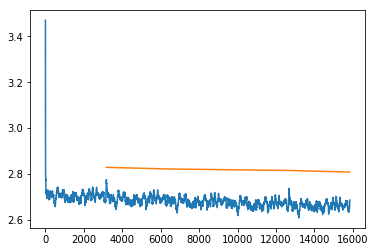

In [32]:
if TRAIN:
    learn.recorder.plot_losses()

## Text Generation

In [49]:
def generate_step(learner, context, context_length, temp=1):

    model = learner.model
    
    if GPU:
        context = LongTensor(context[-context_length:]).view(-1,1).cuda()
    else:
        context = LongTensor(context[-context_length:]).view(-1,1).cpu()
    
    context = torch.autograd.Variable(context)
    
    model.reset()
    model.eval()

    # forward pass the "context" into the model
    result, *_ = model(context)
    result = result[-1]

    # set unk and pad to 0 prob
    # i.e. never pick unknown or pad
    result[0] = -np.inf
    result[1] = -np.inf

    # softmax and normalize
    probabilities = F.softmax(result/temp, dim=0)
    probabilities = np.asarray(probabilities.detach().cpu(), dtype=np.float)
    probabilities /= np.sum(probabilities) 
    return probabilities

def print_words(context):
    for i in range(len(context)):
        
        step = context[i]

        word = data_lm.valid_ds.vocab.textify([step])

        if word == 'xeol':
            word = '\n'
        elif 'xbol' in word:
            word = word
        elif word == 'xeos': 
            print(word)
            break
            
        print(word, end=' ')   

def generate_text(learner, seed_text=['xbos'], max_len=500, GPU=False, context_length=20, beam_width=5, verbose=True, temp=1):
    """Generates text with a given learner and returns best options.

    Parameters
    ----------
    learner : RNNLearner Language Model (RNNLearner.language_model())
        Fastai RNNLearner with tokenized language model data already loaded 
        
    seed_text : list or str
        List of strings where each item is a token. (e.g. ['the', 'cat']) or string that is split on white space

    max_len : int
        Number of words in generated sequence
        
    gpu : bool
        If you're using a GPU or not...
    
    context_length : int
        Amount of words that get input as "context" into the model. Set to 0 for no limit   
        
    beam_width : int
        How many new word indices to try out...computationally expensive
    
    verbose : bool
        If True, prints every possible context for a given word cycle

    temperature : float
        Scales the logits before softmax. A higher temp (>1) increases variety whereas a low temp (<=1) will often result in a loop

    Returns
    -------
    context_and_scores : list of lists
        Returns a sorted list of the entire tree search of contexts and their respective scores in the form:
        [[context, score], [context, score], ..., [context, score]]
    """
        
    if isinstance(seed_text, str):
        seed_text = data_lm.train_ds.vocab.numericalize(seed_text.split(' '))
    
    
    # Width for the beam search, to be externalized along with general decoding
    beam_width = beam_width
    
    # List of candidate word sequence. We'll maintain #beam_width top sequences here.
    # The context is a list of words, the scores are the sum of the log probabilities of each word
    context_and_scores = [[seed_text, 0.0]]
    
    # Loop over max number of words
    for word_number in range(max_len):
        print(f'Generating word: {word_number+1} / {max_len}')

        candidates = []
        
        # For each possible context that we've generated so far, generate new probabilities, 
        # and pick an additional #beam_width next candidates
        for i in range(len(context_and_scores)):
            # Get a new sequence of word indices and log-probability
            # Example: [[2, 138, 661], 23.181717]
            context, score = context_and_scores[i]
            
            # Obtain probabilities for next word given the context 
            probabilities = generate_step(learner, context, context_length, temp)

            # Multinomial draw from the probabilities
            multinom_draw = np.random.multinomial(beam_width, probabilities)
            top_probabilities = np.argwhere(multinom_draw != 0).flatten()
                        
            #For each possible new candidate, update the context and scores
            for j in range(len(top_probabilities)):
                next_word_idx = top_probabilities[j]
                new_context = context + [next_word_idx]
                candidate = [new_context, (score - np.log(probabilities[next_word_idx]))]
                candidates.append(candidate)
        
        #update the running tally of context and scores and sort by probability of each entry
        context_and_scores = candidates
        context_and_scores = sorted(context_and_scores, key = lambda x: x[1]) #sort by top entries
#         np.random.shuffle(context_and_scores)

        context_and_scores = context_and_scores[:15] #for now, only keep the top 15 to speed things up but we can/should change this to beam_width or something else
        
        if verbose:
            for context, score in context_and_scores:
                print_words(context)
                print('\n')
    
    return context_and_scores
    

In [68]:
final_scores = generate_text(learn, GPU=GPU, seed_text='xbos xbol-1', max_len=80, context_length=200, beam_width=3, verbose=False, temp=1.5)

Generating word: 1 / 80
Generating word: 2 / 80
Generating word: 3 / 80
Generating word: 4 / 80
Generating word: 5 / 80
Generating word: 6 / 80
Generating word: 7 / 80
Generating word: 8 / 80
Generating word: 9 / 80
Generating word: 10 / 80
Generating word: 11 / 80
Generating word: 12 / 80
Generating word: 13 / 80
Generating word: 14 / 80
Generating word: 15 / 80
Generating word: 16 / 80
Generating word: 17 / 80
Generating word: 18 / 80
Generating word: 19 / 80
Generating word: 20 / 80
Generating word: 21 / 80
Generating word: 22 / 80
Generating word: 23 / 80
Generating word: 24 / 80
Generating word: 25 / 80
Generating word: 26 / 80
Generating word: 27 / 80
Generating word: 28 / 80
Generating word: 29 / 80
Generating word: 30 / 80
Generating word: 31 / 80
Generating word: 32 / 80
Generating word: 33 / 80
Generating word: 34 / 80
Generating word: 35 / 80
Generating word: 36 / 80
Generating word: 37 / 80
Generating word: 38 / 80
Generating word: 39 / 80
Generating word: 40 / 80
Generatin

In [69]:
#print all of the final options of songs
for song, score in final_scores:
    print_words(song)
    print(score)
    print('\n')

xbos xbol-1 hello , baby , when your love is gone 
 xbol-2 we can see that we 're all alone 
 xbol-3 hello , baby , won 't you just let me be alone 
 xbol-4 'cause i still love you 
 xbol-5 
 xbol-6 won 't you stay ? 
 xbol-7 won 't you love me until the end ? 
 xbol-8 won 't you love me , won 't you come again ? 
 xbol-9 won 't you come 162.0649492646885


xbos xbol-1 hello , baby , when your love is gone 
 xbol-2 we can see that we 're all alone 
 xbol-3 hello , baby , won 't you just let me be alone 
 xbol-4 'cause i still love you 
 xbol-5 
 xbol-6 won 't you stay ? 
 xbol-7 won 't you love me until the end ? 
 xbol-8 won 't you love me ? won 't you ? 
 xbol-9 won 't you love me too 163.1574106549538


xbos xbol-1 hello , baby , when your love is gone 
 xbol-2 we can see that we 're all alone 
 xbol-3 hello , baby , won 't you just let me be alone 
 xbol-4 'cause i still love you 
 xbol-5 
 xbol-6 won 't you stay ? 
 xbol-7 won 't you love me until the end ? 
 xbol-8 won 't you tel